In [6]:
import xarray as xr
import fsspec

In [16]:
# remote zarr dataset
dataset_name="gsla_nrt"
url = f's3://imos-data-lab-optimised/parquet/loz_test/{dataset_name}.zarr/'
ds = xr.open_zarr(fsspec.get_mapper(url, anon=True), consolidated=True)
ds

<xarray.Dataset> Size: 1GB
Dimensions:     (TIME: 115, LATITUDE: 351, LONGITUDE: 641)
Coordinates:
  * LATITUDE    (LATITUDE) float64 3kB -60.0 -59.8 -59.6 -59.4 ... 9.6 9.8 10.0
  * LONGITUDE   (LONGITUDE) float64 5kB 57.0 57.2 57.4 ... 184.6 184.8 185.0
  * TIME        (TIME) datetime64[ns] 920B 2024-01-01 ... 2024-04-20T06:00:00
Data variables:
    GSL         (TIME, LATITUDE, LONGITUDE) float64 207MB dask.array<chunksize=(1, 350, 640), meta=np.ndarray>
    GSLA        (TIME, LATITUDE, LONGITUDE) float64 207MB dask.array<chunksize=(1, 350, 640), meta=np.ndarray>
    UCUR        (TIME, LATITUDE, LONGITUDE) float64 207MB dask.array<chunksize=(1, 350, 640), meta=np.ndarray>
    UCUR_MEAN   (TIME, LATITUDE, LONGITUDE) float64 207MB dask.array<chunksize=(1, 350, 640), meta=np.ndarray>
    VCUR        (TIME, LATITUDE, LONGITUDE) float64 207MB dask.array<chunksize=(1, 350, 640), meta=np.ndarray>
    VCUR_MEAN   (TIME, LATITUDE, LONGITUDE) float64 207MB dask.array<chunksize=(1, 350, 640), meta=np.ndarray>
    end_time    (TIME) datetime64[ns] 920B dask.array<chunksize=(1,), meta=np.ndarray>
    filename    (TIME) <U54 25kB dask.array<chunksize=(1,), meta=np.ndarray>
    start_time  (TIME) datetime64[ns] 920B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/35)
    Conventions:                   CF-1.6,IMOS-1.4
    abstract:                      Gridded (adjusted) sea level anomaly (GSLA...
    acknowledgement:               Any users of IMOS data are required to cle...
    author:                        Pilo, Gabriela S
    author_email:                  gabriela.semolinipilo@csiro.au
    citation:                      The citation in a list of references is: "...
    ...                            ...
    project:                       Integrated Marine Observing System (IMOS)
    references:                    http://imos.aodn.org.au/oceancurrent
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    time_coverage_end:             2024-04-22T20:04:38Z
    time_coverage_start:           2024-03-28T08:04:51Z
    title:                         Gridded Sea Level Anomaly - Australia Region

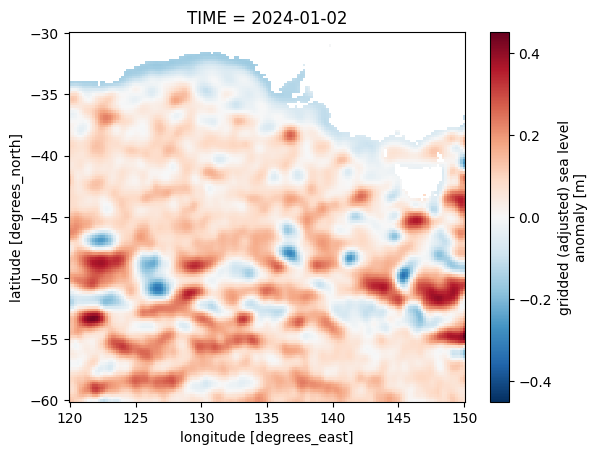

In [8]:
ds.GSLA.sel(TIME='2024-01-02', LONGITUDE=slice(120, 150), LATITUDE=slice(-60, -30)).plot()  # LATITUDE slice is reversed order from L3S

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

import pandas as pd

def plot_gsla_timeseries_subplots(ds, time_start, lon_slice, lat_slice):
    """
    Create subplots of timeseries data over specified time intervals and spatial slices.

    Parameters:
    - ds (xarray.Dataset): Dataset containing the variable of interest (e.g., GSLA).
    - time_start (str): Start time in 'YYYY-MM-DD' format.
    - lon_slice (slice): Longitude slice (e.g., slice(120, 150)).
    - lat_slice (slice): Latitude slice (e.g., slice(-60, -30)).
    """
    # Parse start time string to datetime
    start_time = pd.to_datetime(time_start)

    # Create a new figure with specified number of subplots in a row
        # Create a 3x2 grid of subplots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

    # Plot data on each subplot. We're plotting the next 6 time stamps (requiring obviously that they all exist)
    ii = 0
    iTime = list(ds.TIME.values).index(ds.sel(TIME=time_start , method='nearest').TIME)
    cbar_ax = fig.add_axes([0.99, 0.1, 0.02, 0.8])  # Adjust the position and size of the colorbar
    
    for i in range(3):
        for j in range(2):
            time_index = iTime + ii
            gsla = ds.GSLA.isel(TIME=time_index).sel(LONGITUDE=lon_slice, LATITUDE=lat_slice)
            uData = ds.UCUR.isel(TIME=time_index).sel(LONGITUDE=lon_slice, LATITUDE=lat_slice)
            vData = ds.VCUR.isel(TIME=time_index).sel(LONGITUDE=lon_slice, LATITUDE=lat_slice)
            lonData = gsla.LONGITUDE.values
            latData = gsla.LATITUDE.values

            cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'white', 'red'])

            p = axes[i, j].pcolor(lonData, latData, gsla, cmap=cmap_custom, vmin=-.5, vmax=.5)
            #axes[i, j].quiver(lonData, latData, uData, vData, units='width')
            axes[i, j].set_title(f'{np.datetime_as_string(ds.TIME.values[iTime + ii])}')
            ii += 1

    # Add a common colorbar
    fig.colorbar(p, cax=cbar_ax, label='GSLA')

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_904971/1722478904.py:46: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(p, cax=cbar_ax, label='GSLA')
/tmp/ipykernel_904971/1722478904.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


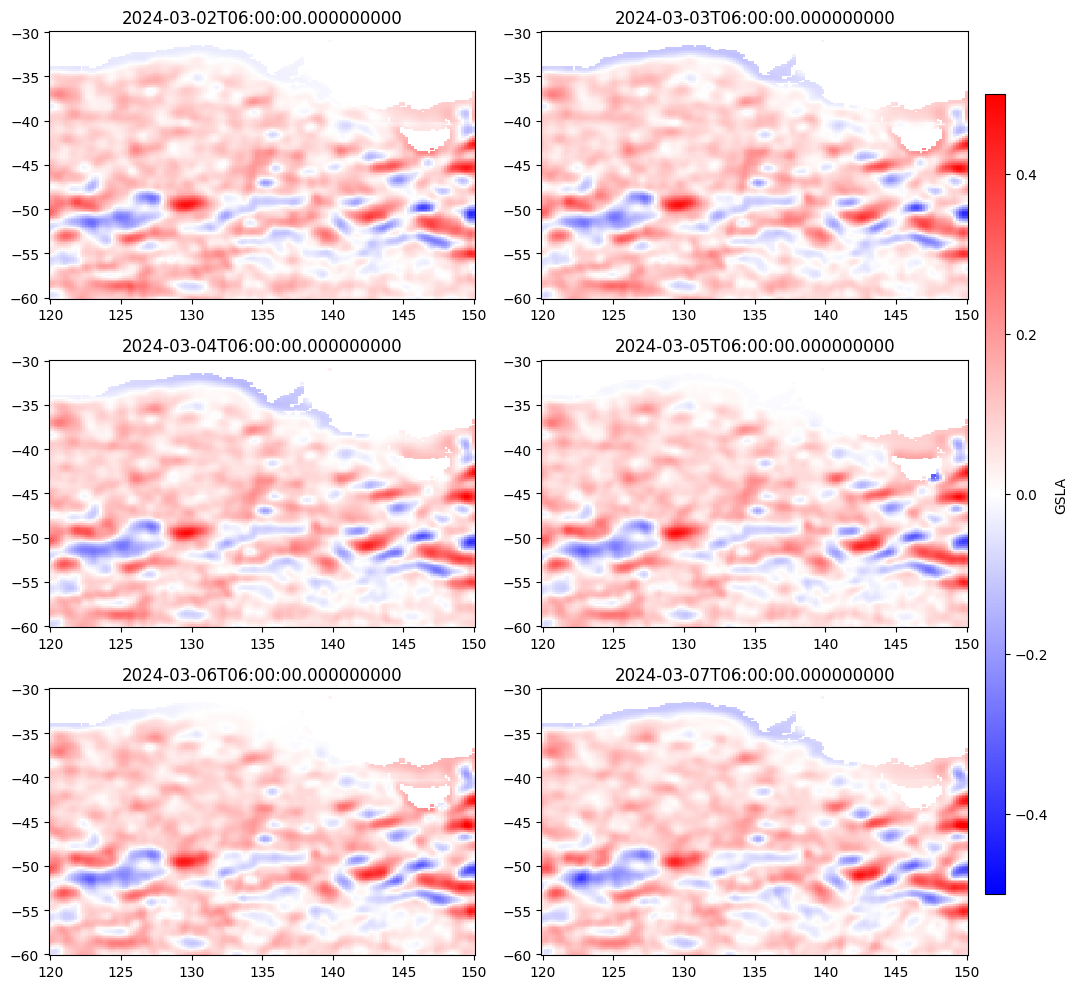

In [18]:
time_start = '2024-03-02'
lon_slice = slice(120, 150)
lat_slice = slice(-60, -30)

plot_gsla_timeseries_subplots(ds, time_start, lon_slice, lat_slice)
